# <span style="color: #f00;"> PROJET Numéro 7: Implémentez un modèle de scoring </span> 

# Notebook2: Notebook de simulation et comparaison des modèles

## <span style="color: ##0101DF;">Importation des bibliothèques </span> 

In [1]:
# pandas and numpy for data manipulation
import pandas as pd
print('Pandas',pd.__version__)
import numpy as np
print('Numpy',pd.__version__)
# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
print('Matplotlib',pd.__version__)
import seaborn as sns
print('Seaborn',pd.__version__)

import time
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from lime.lime_tabular import LimeTabularExplainer
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import learning_curve
import joblib
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
import pickle
from sklearn.feature_selection import VarianceThreshold
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix,precision_score


# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')


Pandas 1.2.4
Numpy 1.2.4
Matplotlib 1.2.4
Seaborn 1.2.4


## <span style="color: ##0101DF;">Quelques fonctions utiles</span> 

In [2]:
df_var = joblib.load('C:/Users/Agboto/Desktop/Projet_OpenClassrooms_Data_Science/Projet7_openclassrooms/df_var.joblib')

def col_desc(table_name_kw,column_name_kw):
    res = df_var[(df_var['Table'].str.contains(table_name_kw)) & (df_var['Column'].str.contains(column_name_kw))].loc[:,'Table':'Description']
    print(res.values)

In [3]:
col_desc('train','TARGET')

[['application_{train|test}.csv' 'TARGET'
  'Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases) ']]


In [4]:
def select_col_by_type(df,col_type) : 
    var_object = []
    for col in df.select_dtypes(col_type) :
        var_object.append(col)
    return var_object

def missing_presence(df, figsize):
    
    # Affichage de la forme du dataset
    print("Le dataset contient {} lignes et {} colonnes.".format(df.shape[0], df.shape[1]))
    
    # Proportion de valeurs nulles
    prop_nan_df = df.isna().sum().sum()/(df.shape[0]*df.shape[1])*100
    print('Il y a {:.2f}% de NaN.'.format(prop_nan_df))
    
    # Visualisation des valeurs non nulles
    df_null=(df.notnull().sum()/df.shape[0]).sort_values(ascending=False)*100
    
    # Création de la figure
    plt.figure(figsize=figsize)
    plt.style.use('ggplot')
    ax=sns.barplot(x=df_null.values, y=df_null.index, orient='h')
    plt.title('Proportion de valeurs présentes par colonne')
    plt.xticks(rotation=0)
    plt.yticks(fontsize=14)
    plt.ylabel("Nom de la colonne")
    plt.xlabel('Pourcentage de valeurs présentes (%)')

    # Affichage de la valeur à côté des barres
    for index, value in enumerate(df_null.values):
        plt.text(value, index+0.4, str(value.round(2)))

    plt.show()

    
def setup_plot():
    plt.rcParams["axes.grid.axis"] = "y"
    plt.rcParams["axes.grid"] = True
    plt.rcParams["legend.fontsize"] = 14
    plt.rc('grid', linestyle="dashed", color='lightgrey', linewidth=1)
    plt.rcParams["xtick.labelsize"] = 15
    plt.rcParams["ytick.labelsize"] = 15

def select_col_by_type(df,col_type) : 
    var_object = []
    for col in df.select_dtypes(col_type) :
        var_object.append(col)
    return var_object

def handle_type(df) :
    cat_var = select_col_by_type(df,"object")
    int_var = select_col_by_type(df,"int64")
    float_var = select_col_by_type(df,"float64")
    num_var = int_var + float_var
    return cat_var, num_var

def imputer_nan(df, strategy, var_type):
    imputer = SimpleImputer(missing_values=np.nan, strategy=strategy)
    imputer = imputer.fit(df[var_type])
    array_type = imputer.transform(df[var_type])
    df_type = pd.DataFrame(array_type, columns=var_type)
    return df_type

def trans_func():
    control_train = pd.read_csv(data_path +'application_train.csv')
    train_data = control_train[control_train.columns[control_train.isna().sum()/control_train.shape[0] < 0.5]]
    cat_var, num_var = handle_type(train_data)
    df_cat = imputer_nan(train_data, "most_frequent", cat_var)
    df_num = imputer_nan(train_data, "median", num_var)
    dummies = pd.get_dummies(df_cat, drop_first=True)
    concatenate_df = pd.concat([df_num, dummies], axis=1)
    data = concatenate_df.sample(n=500, random_state=1)
    return data

## <span style="color: ##0101DF;">Chemins pour les exportations </span> 

In [5]:
# Initialisation d'un compteur
t = time.time() 

# Chemins d'accès aux fichiers
path_data_csv = "C:/Users/Agboto/Desktop/Projet_OpenClassrooms_Data_Science/Projet7_openclassrooms/data_csv/"
path_data = 'C:/Users/Agboto/Desktop/Projet_OpenClassrooms_Data_Science/Projet7_openclassrooms/'
path_features = 'C:/Users/Agboto/Desktop/Projet_OpenClassrooms_Data_Science/Projet7_openclassrooms/'
path_feature_selection = 'C:/Users/Agboto/Desktop/Projet_OpenClassrooms_Data_Science/Projet7_openclassrooms/'
path_models = '../OC_DS_P7/models/'
path_results = '../OC_DS_P7/results/'

# Introduction

Dans ce notebook, je vais tout d'abord mettre en place un modèle de régression comme base puis une comparaison d'algorithmes de classification, déterminer celui qui sera le plus adapté à notre problématique (en prenant en compte le fait qu'il y ait un déséquilibre de TARGET) tout en montrant l'importance des features puis séléctionner les features pertinentes pour les visualisations sur notre dashboard.

L'objectif de ce projet est d'utiliser les données historiques des demandes de prêt pour prédire si un demandeur sera en mesure ou non de rembourser un prêt. "Il s'agit d'une classification supervisée".

apprentissage superviser : Les étiquettes sont incluses dans les données d'apprentissage et l'objectif est de former un modèle pour apprendre à prédire les étiquettes à partir des caractéristiques. Classification : L'étiquette est une variable binaire, 0 (remboursera le prêt à temps), 1 (aura des difficultés à rembourser le prêt)".

Il y a beaucoup plus de prêts remboursés à temps que de prêts non remboursés.

Une fois que nous entrons dans des modèles d'apprentissage automatique plus sophistiqués, nous pouvons pondérer les classes par leur représentation dans les données pour refléter ce déséquilibre.
Le projet concerne la réalisation d'une application de Crédit Scoring basée sur des technologies de Machine Learning. L'analyse et le traitement des données ont déjà été réalisés dans le notebook 

Le présent notebook est dédié à la modélisation. Le modèle sera in fine déployé via une application web développée avec la technologie Dash. Le code de l'application est inscrit dans le notebook 
La matrice de confusion est utilisée pour présenter le nombre de vrais positifs (correctement prédits comme défaillants), de vrais négatifs (correctement prédits comme non défaillants), de faux positifs (incorrectement prédits comme défaillants), de faux négatifs (incorrectement prédits comme non défaillants).

In [6]:
############################################

# Préparation du Dataset final

In [7]:
# jeux de données réduit à l'ensembles des variables esentielles décrivants chaque client et ayant un poucentages par colonne
# de valeurs manquantes différents de 50%
cdf = pd.read_csv(path_data_csv +'application_train.csv',encoding='utf-8')
cdf.shape

(307511, 122)

In [8]:
train_data = cdf[cdf.columns[cdf.isna().sum()/cdf.shape[0] < 0.5]]
train_data

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
train_data.dtypes

SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 81, dtype: object

 ## <span style="color: ##0101DF;"> Imputation des valeurs manquantes et Label des variables catégorielles </span> 

In [10]:
from sklearn.impute import SimpleImputer
cat_var, num_var = handle_type(train_data)

In [11]:
df_cat = imputer_nan(train_data, "most_frequent", cat_var)
df_num = imputer_nan(train_data, "median", num_var)

In [12]:
dummies = pd.get_dummies(df_cat, drop_first=True)

In [13]:
concatenate_df = pd.concat([df_num, dummies], axis=1)

In [14]:
data = concatenate_df.sample(n=2000, random_state=1)

In [15]:
X = data.drop(columns=['TARGET'])
y = data['TARGET']

 ## <span style="color: ##0101DF;"> Colonnes utiles pour la préparation du Dashboard </span> 

In [16]:
col_util = ['EXT_SOURCE_3', 'DAYS_LAST_PHONE_CHANGE', 'REGION_POPULATION_RELATIVE',
            'TOTALAREA_MODE', 'HOUR_APPR_PROCESS_START', 'DAYS_BIRTH',
            'DAYS_EMPLOYED', 'AMT_INCOME_TOTAL', 'OBS_60_CNT_SOCIAL_CIRCLE',
            'FLAG_DOCUMENT_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_2',
            'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_ANNUITY', 'DAYS_ID_PUBLISH',
            'DEF_30_CNT_SOCIAL_CIRCLE', 'AMT_GOODS_PRICE', 'AMT_CREDIT', 'CNT_FAM_MEMBERS'
            # 'NAME_HOUSING_TYPE', 'FLAG_OWN_REALTY','ORGANIZATION_TYPE'
           ]

L'utilisation de mesures plus simples comme le score de précision peut être trompeuse. Dans un jeu de données avec des classes très déséquilibrées, le classificateur "prédira" toujours la classe la plus courante sans effectuer aucune analyse des caractéristiques et il aura un taux de précision élevé, évidemment pas le bon

Nous pouvons voir une précision (accuracy) de 92 %, nous obtenons une précision très élevée car il prédit principalement la classe majoritaire qui est 0 (non défaut de paiement). 

# Technique de rééchantillonnage (Resampling Technique)
> Une technique largement adoptée pour traiter des ensembles de données très déséquilibrés est appelée rééchantillonnage. Elle consiste à retirer des échantillons de la classe majoritaire (**sous-échantillonnage** en anglais _**under-sampling**_) et/ou à ajouter d'autres exemples de la classe minoritaire (**sur-échantillonnage** en anglais _**over-sampling**_). 
Malgré l'avantage des cours d'équilibrage, ces techniques ont aussi leurs faiblesses (il n'y a pas de repas gratuit).

La mise en œuvre la plus simple du sur-échantillonnage consiste à dupliquer des enregistrements aléatoires de la classe minoritaire, ce qui peut entraîner une surpêche.

Dans le sous-échantillonnage, la technique la plus simple consiste à supprimer des enregistrements aléatoires de la classe majoritaire, ce qui peut entraîner une perte d'informations. 

## <span style="color: ##0101DF;"> Random Under-Sampling (Sous-échantillonnage aléatoire) </span> 
Le sous-échantillonnage peut être défini comme la suppression de certaines observations de la classe majoritaire. Ceci est fait jusqu'à ce que la classe majoritaire et minoritaire soit équilibrée.

Le sous-échantillonnage peut être un bon choix lorsque vous avez une tonne de données - pensez à des millions de lignes. Mais un inconvénient du sous-échantillonnage est que nous supprimons des informations qui peuvent être précieuses.

## <span style="color: ##0101DF;"> Random Over-Sampling(Sur-échantillonnage aléatoire) </span> 

Le suréchantillonnage peut être défini comme l'ajout de plus de copies à la classe minoritaire. Le suréchantillonnage peut être un bon choix lorsque vous n'avez pas une tonne de données avec lesquelles travailler.

Un inconvénient à prendre en compte lors du sous-échantillonnage est qu'il peut entraîner un surajustement et une mauvaise généralisation de votre ensemble de test.

# Balance data with the imbalanced-learn python module(Équilibrer les données avec le module python d'apprentissage déséquilibré)
Un certain nombre de techniques de rééchantillonnage plus sophistiquées ont été proposées dans la littérature scientifique.

Par exemple, on peut regrouper les enregistrements de la classe majoritaire, et faire le sous-échantillonnage en supprimant des enregistrements de chaque cluster, cherchant ainsi à préserver l'information. Dans le suréchantillonnage, au lieu de créer des copies exactes des enregistrements de la classe minoritaire, nous pouvons introduire de petites variations dans ces copies, créant ainsi des échantillons synthétiques plus diversifiés.

Appliquons certaines de ces techniques de rééchantillonnage, en utilisant la bibliothèque Python "balanced-learn". Il est compatible avec scikit-learn et fait partie des projets scikit-learn-contrib. 

## <span style="color: ##0101DF;"> Sur-chantillonnage(Oversampling) en utilisant la méthode SMOTE </span> 
**SMOTE** with Imbalance Data using **imblearn module**

Technique de suréchantillonnage synthétique minoritaire (SMOTE)
Cette technique génère des données synthétiques pour la classe minoritaire.

SMOTE (Synthetic Minority Oversampling Technique) fonctionne en choisissant au hasard un point de la classe minoritaire et en calculant les k plus proches voisins pour ce point. Les points synthétiques sont ajoutés entre le point choisi et ses voisins.

L'algorithme SMOTE fonctionne en 4 étapes simples :

* Choisissez une classe minoritaire comme vecteur d'entrée
* Trouver ses k voisins les plus proches (k_neighbors est spécifié comme argument dans la fonction SMOTE())
* Choisissez l'un de ces voisins et placez un point synthétique n'importe où sur la ligne joignant le point considéré et son voisin choisi
* Répétez les étapes jusqu'à ce que les données soient équilibrées 

## <span style="color: ##0101DF;"> Sur-chantillonnage(Oversampling) avec la méthode SMOTE </span>  

In [17]:
smote = SMOTE(random_state=42) # Smote

In [18]:
X_smote, y_smote = smote.fit_resample(X[col_util], y) # les colonnes spécifiques pour le Dashboard

In [19]:
X_smote.index

RangeIndex(start=0, stop=3684, step=1)

In [20]:
X_smote.shape  

(3684, 19)

In [21]:
print(X_smote.shape[0] - X[col_util].shape[0], 'nouveau points générés par la méthode SMOTE')

1684 nouveau points générés par la méthode SMOTE


In [22]:
X_smote.head()

,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,REGION_POPULATION_RELATIVE,TOTALAREA_MODE,HOUR_APPR_PROCESS_START,DAYS_BIRTH,DAYS_EMPLOYED,AMT_INCOME_TOTAL,OBS_60_CNT_SOCIAL_CIRCLE,FLAG_DOCUMENT_3,OBS_30_CNT_SOCIAL_CIRCLE,EXT_SOURCE_2,DEF_60_CNT_SOCIAL_CIRCLE,AMT_ANNUITY,DAYS_ID_PUBLISH,DEF_30_CNT_SOCIAL_CIRCLE,AMT_GOODS_PRICE,AMT_CREDIT,CNT_FAM_MEMBERS
0,0.602386,-1237.0,0.005313,0.0688,9.0,-20614.0,365243.0,135000.0,0.0,1.0,0.0,0.622652,0.0,31617.0,-3098.0,0.0,585000.0,654498.0,2.0
1,0.492060,-379.0,0.010643,0.0688,17.0,-9080.0,-1080.0,135000.0,1.0,1.0,1.0,0.655960,0.0,25393.5,-1743.0,0.0,202500.0,234576.0,1.0
2,0.535276,-343.0,0.032561,0.1682,14.0,-15933.0,-114.0,112500.0,1.0,1.0,1.0,0.670793,0.0,16753.5,-4424.0,0.0,139500.0,157914.0,1.0
3,0.345785,-1269.0,0.011703,0.0688,16.0,-9926.0,-1061.0,247500.0,1.0,1.0,1.0,0.486120,1.0,36292.5,-2474.0,1.0,1125000.0,1125000.0,2.0
4,0.227613,-524.0,0.010006,0.0355,8.0,-11757.0,-1593.0,202500.0,0.0,1.0,0.0,0.247563,0.0,35158.5,-81.0,0.0,900000.0,900000.0,2.0


In [23]:
y_smote.value_counts()

0.0    1842
1.0    1842
Name: TARGET, dtype: int64

In [24]:
Xscaled = StandardScaler().fit_transform(X_smote)

In [25]:
df_scaled = pd.DataFrame(Xscaled, columns=X_smote.columns)

In [26]:
df_scaled.shape # augmentation du nombre de lignes puisque c'est un sur-echant

(3684, 19)

# Trainset et Testset

In [27]:
X_train, X_test, y_train, y_test = train_test_split(df_scaled, y_smote, test_size=0.2, random_state=1)

## <span style="color: ##0101DF;"> Rebalancing par le paramètre du classifier class_weight = 'balanced' </span>  

In [28]:
imbalanced_test = y_test.value_counts()[0].sum()/y_test.value_counts()[1].sum()
imbalanced_test

1.058659217877095

In [29]:
imbalanced_train = y_train.value_counts()[0].sum()/y_train.value_counts()[1].sum()
imbalanced_train

0.9858490566037735

In [30]:
import xgboost
print('xgboost version:',xgboost.__version__)
from xgboost import XGBClassifier

import catboost
print('catboost version:',catboost.__version__)
from catboost import CatBoostClassifier

import lightgbm
print('lightgbm version:',lightgbm.__version__)
from lightgbm import LGBMClassifier

xgboost version: 1.5.0
catboost version: 0.26.1
lightgbm version: 3.3.1


                   name  train_accuracy  test_accuracy  train_time  \
0           Naive Bayes        0.697659       0.671642    0.025434   
1   logistic regression        0.714286       0.693351    0.241217   
2         Decision Tree        1.000000       0.881954    0.032030   
3         Random Forest        1.000000       0.956581    0.499457   
4       LGBM Classifier        1.000000       0.963365    0.302527   
5  Catboost Classifier         0.965389       0.936228    0.893816   
6        MLP Classifier        0.914150       0.843962    8.253869   

                                               model  
0                                     (GaussianNB())  
1                           (LogisticRegressionCV())  
2                         (DecisionTreeClassifier())  
3  ((DecisionTreeClassifier(max_features='auto', ...  
4                                 (LGBMClassifier())  
5  (([DecisionTreeRegressor(criterion='friedman_m...  
6  (MLPClassifier(alpha=0.1, hidden_layer_sizes=(...  

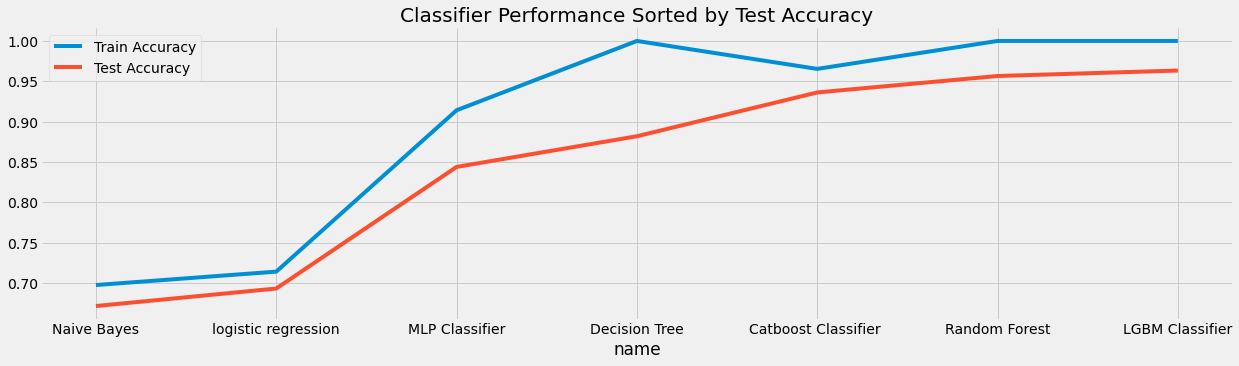

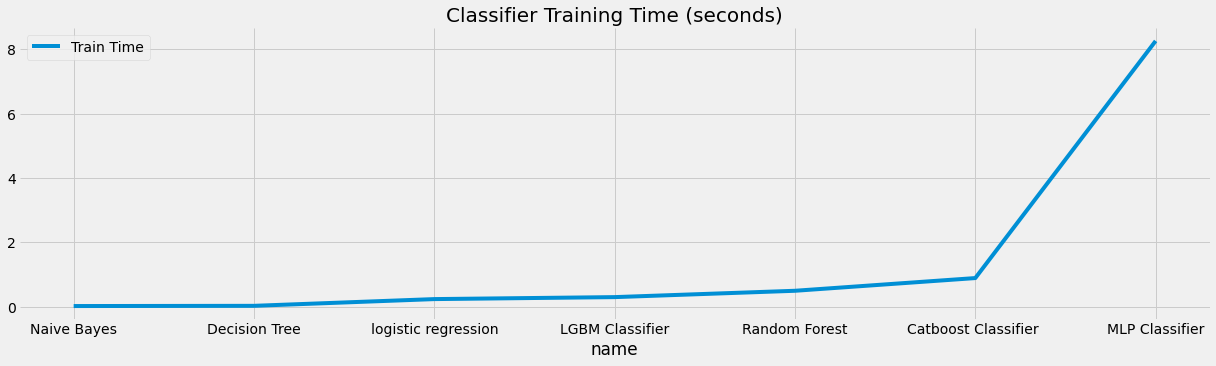

In [31]:
trained_models = []  # garder une trace de tous les détails pour les modèles que nous formons 
def train_model(model, data, labels):
    pipe = Pipeline([('clf', model["clf"])])
    start_time = time.time()
    pipe.fit(X_train, y_train)
    train_time = time.time() - start_time
    train_accuracy = pipe.score(X_train, y_train)
    test_accuracy = pipe.score(X_test, y_test)
    #train_accuracy = roc_auc_score(X_train, y_train)
    #test_accuracy = roc_auc_score(X_test, y_test)
    model_details = {
                    "name": model["name"], "train_accuracy": train_accuracy,
                     "test_accuracy": test_accuracy, "train_time": train_time, 
                     "model": pipe
                    }
    return model_details


models = [
                {"name": "Naive Bayes", "clf": GaussianNB()},
                {"name": "logistic regression", "clf": LogisticRegressionCV()},
                {"name": "Decision Tree", "clf": DecisionTreeClassifier()},
                {"name": "Random Forest","clf": RandomForestClassifier(n_estimators=100)},
                {"name": "LGBM Classifier","clf": lgb.LGBMClassifier(n_estimators=100)},
                {"name": "Catboost Classifier ","clf": GradientBoostingClassifier(n_estimators=100)},
                {"name": "MLP Classifier", "clf": MLPClassifier(solver='adam', alpha=1e-1, 
                                                                hidden_layer_sizes=(10, 10, 5, 2), max_iter=500, 
                                                                random_state=42)}
    ]

for model in models:
    model_details = train_model(model, X, y)
    trained_models.append(model_details)


# regardons l'accuracy et le temps d'exécution
#setup_plot()
model_df = pd.DataFrame(trained_models)
print(model_df)
model_df.sort_values("test_accuracy", inplace=True)
ax = model_df[["train_accuracy", "test_accuracy", "name"]].plot(
    kind="line", x="name", figsize=(19, 5), title="Classifier Performance Sorted by Test Accuracy")
ax.legend(["Train Accuracy", "Test Accuracy"])
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 3)),
                (p.get_x() * 1.005, p.get_height() * 1.005))

ax.title.set_size(20)
plt.box(False)

model_df.sort_values("train_time", inplace=True)
ax = model_df[["train_time", "name"]].plot(kind="line", x="name", figsize=(
    19, 5), grid=True, title="Classifier Training Time (seconds)")
ax.title.set_size(20)
ax.legend(["Train Time"])
plt.box(False)

## <span style="color: ##0101DF;"> Comparaison de plusieurs Classifiers et definition de fonctions </span>  

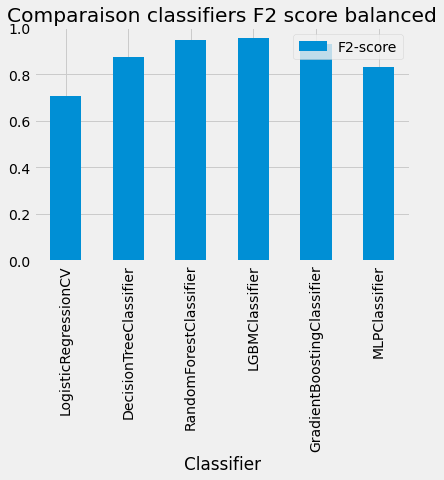

In [32]:
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, fbeta_score
# Comparaison de 7 algorithmes de classification

classifiers = [LogisticRegressionCV(),  
               DecisionTreeClassifier(),
               RandomForestClassifier(random_state=2),
               lgb.LGBMClassifier(n_estimators=100),
               GradientBoostingClassifier(n_estimators=100),
               MLPClassifier(solver='adam', alpha=1e-1, hidden_layer_sizes=(10, 10, 5, 2), max_iter=500, random_state=42)
              ]

# Enregistrement des scores pour comparaison visuelle
log_cols=["Classifier", "F2-score"]
log = pd.DataFrame(columns=log_cols)

# Création d'un scorer pour cross validation du score FBeta et calcul de ces scores pour chaque classifier

scorer_beta = make_scorer(fbeta_score, beta=2, average = 'weighted')

for clf in classifiers:
    F_Beta2_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring=scorer_beta)
    name = clf.__class__.__name__
    log_entry = pd.DataFrame([[name, F_Beta2_scores.mean()]], columns=log_cols)
    log = log.append(log_entry)

log.plot(x="Classifier", y=["F2-score"], kind="bar")
plt.title("Comparaison classifiers F2 score balanced")
plt.show()

In [33]:
log.nlargest(3,['F2-score'])

,Classifier,F2-score
0,LGBMClassifier,0.954456
0,RandomForestClassifier,0.948753
0,GradientBoostingClassifier,0.929367


### Explication globale - Coefficients de régression logistique 

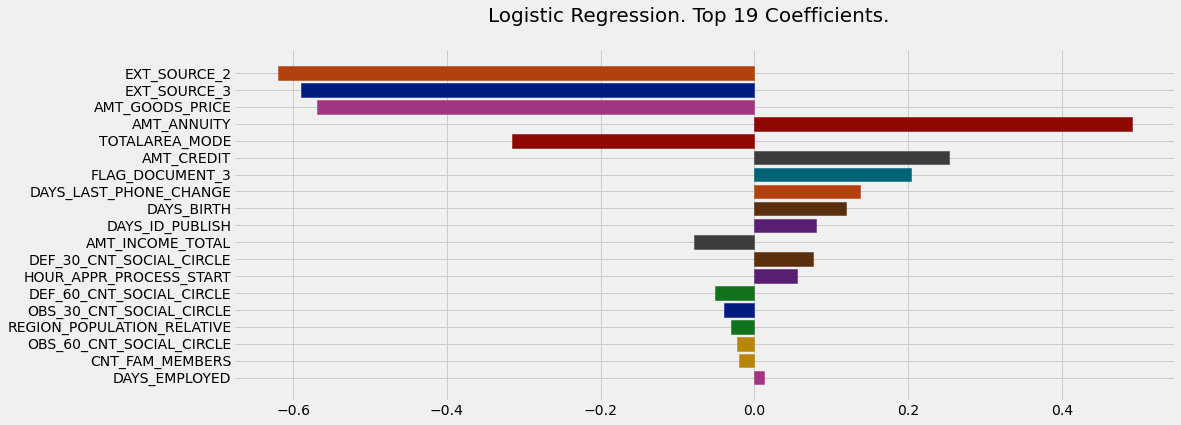

In [34]:
plt.figure(figsize=(15,6))
#X_train, X_test, y_train, y_test = train_test_split(current_data, labels.values, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(df_scaled, y_smote, test_size=0.2, random_state=1)
logistic_reg_coeff = trained_models[1]["model"]["clf"].coef_
color_list =  sns.color_palette("dark", len(df_scaled.columns)) 
top_x = 19
logistic_reg_coeff = trained_models[1]["model"]["clf"].coef_[0]
idx = np.argsort(np.abs(logistic_reg_coeff))[::-1] 
lreg_ax = plt.barh(df_scaled.columns[idx[:top_x]][::-1], logistic_reg_coeff[idx[:top_x]][::-1])
for i,bar in enumerate(lreg_ax):
  bar.set_color(color_list[idx[:top_x][::-1][i]])
  plt.box(False) 
lr_title = plt.suptitle("Logistic Regression. Top " + str(top_x) + " Coefficients.", fontsize=20, fontweight="normal")

### Explications via les scores d'importance des features (modèles basés sur des arbres décisions)

Text(0.5, 0.98, 'Feature Importance for Tree Models. Top 19 Features.')

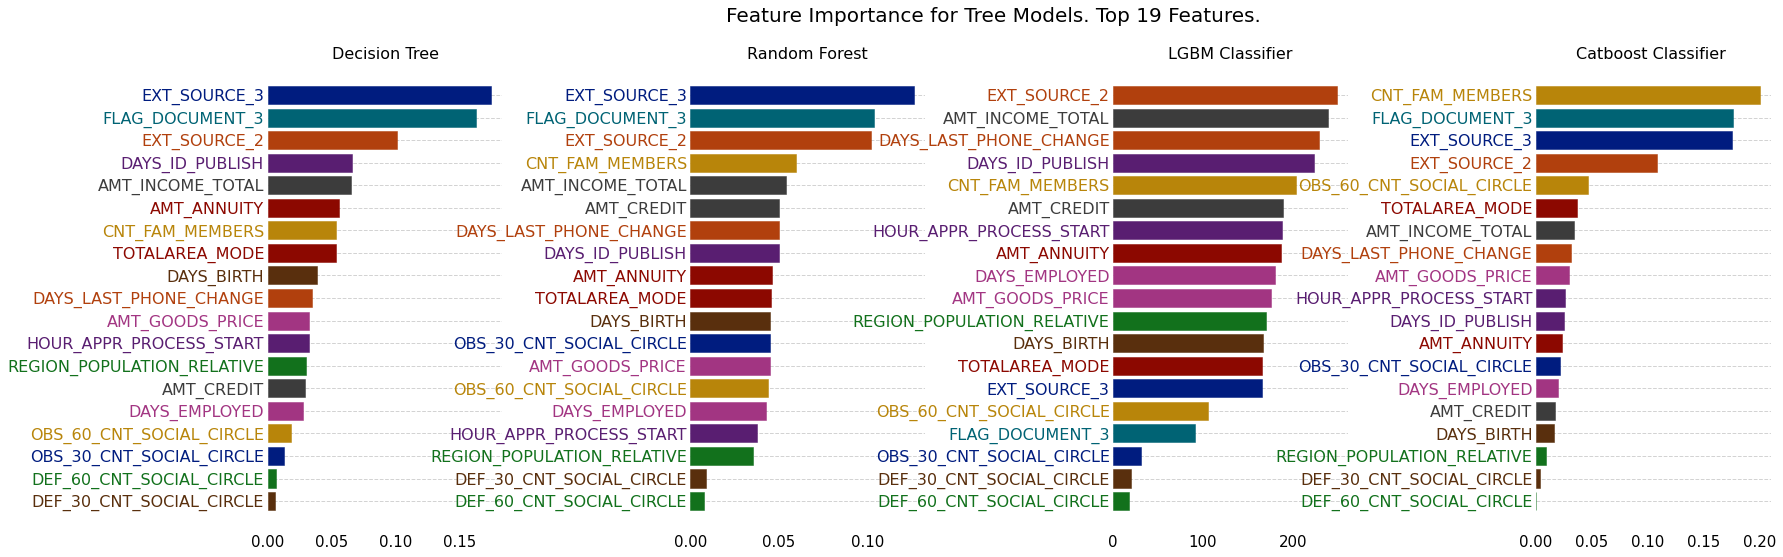

In [35]:
# Create array of tree based models and plot feature importance scores
#current_data
tree_models = []
setup_plot()
color_list = sns.color_palette("dark", len(df_scaled.columns))
top_x = 19  # number of x most important features to show
for model in trained_models:
    if hasattr(model["model"]["clf"], 'feature_importances_'):
        tree_models.append(
            {"name": model["name"], "fi": model["model"]["clf"].feature_importances_})

fig, axs = plt.subplots(1, 4, figsize=(24, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=0.5, wspace=0.8)
axs = axs.ravel()
for i in range(len(tree_models)):
    feature_importance = tree_models[i]["fi"]
    indices = np.argsort(feature_importance)
    indices = indices[-top_x:]
   
    bars = axs[i].barh(range(len(indices)),
                       feature_importance[indices], color='b', align='center')
    axs[i].set_title(tree_models[i]["name"], fontweight="normal", fontsize=16)

    plt.sca(axs[i])
    plt.yticks(range(len(indices)), [df_scaled.columns[j]
                                     for j in indices], fontweight="normal", fontsize=16)
  
    # print(len(plt.gca().get_yticklabels()), len(indices))
    for i, ticklabel in enumerate(plt.gca().get_yticklabels()):
        ticklabel.set_color(color_list[indices[i]])
        #labels.append(ticklabel)
          
   # print("Les features les plus importantes : ",labels)

    for i, bar in enumerate(bars):
        bar.set_color(color_list[indices[i]])
    plt.box(False)

plt.suptitle("Feature Importance for Tree Models. Top " +
             str(top_x) + " Features.", fontsize=20, fontweight="normal")

# Optimisation du modèle LGBMClassifier avec GridSearchCV

In [36]:
param_grid = {
                'num_leaves': [31, 127],
                'reg_alpha': [0.1, 0.5],
                'min_data_in_leaf': [30, 50, 100, 300, 400],
                'lambda_l1': [0, 1, 1.5],
                'lambda_l2': [0, 1]
           }

In [37]:
grid = GridSearchCV(lgb.LGBMClassifier(
    class_weight='balanced', random_state=42), param_grid, scoring="roc_auc", cv=5)

In [38]:
grid.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf

GridSearchCV(cv=5,
             estimator=LGBMClassifier(class_weight='balanced', random_state=42),
             param_grid={'lambda_l1': [0, 1, 1.5], 'lambda_l2': [0, 1],
                         'min_data_in_leaf': [30, 50, 100, 300, 400],
                         'num_leaves': [31, 127], 'reg_alpha': [0.1, 0.5]},
             scoring='roc_auc')

In [39]:
print(grid.best_score_)
print(grid.best_params_)

0.988075121989751
{'lambda_l1': 0, 'lambda_l2': 0, 'min_data_in_leaf': 30, 'num_leaves': 127, 'reg_alpha': 0.1}


In [40]:
model = grid.best_estimator_

In [41]:
model

LGBMClassifier(class_weight='balanced', lambda_l1=0, lambda_l2=0,
               min_data_in_leaf=30, num_leaves=127, random_state=42,
               reg_alpha=0.1)

## Matrice de confusion

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf

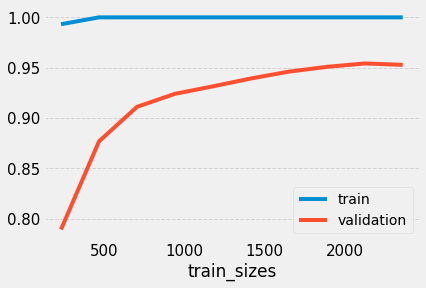

In [42]:
N, train_score, val_score = learning_curve(model, X_train, y_train,
                                           train_sizes=np.linspace(0.1, 1, 10), cv=5)

print(N)
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()

<AxesSubplot:title={'center':'Confusion matrix'}>

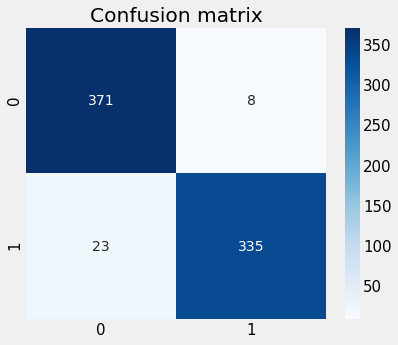

In [43]:
cm= confusion_matrix(y_test, model.predict(X_test))
plt.figure(figsize=(6, 5))
plt.title('Confusion matrix')
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')

In [44]:
from sklearn.metrics import classification_report
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96       379
         1.0       0.98      0.94      0.96       358

    accuracy                           0.96       737
   macro avg       0.96      0.96      0.96       737
weighted avg       0.96      0.96      0.96       737



In [45]:
roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

0.992511902831621

## Courbe de ROC_AUC

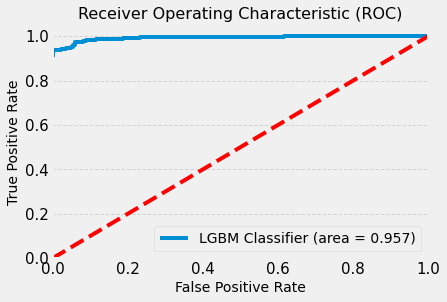

In [46]:
# Building ROC curve
rf_roc_auc = roc_auc_score(y_test, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='LGBM Classifier (area = %0.3f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16)
plt.legend(loc="lower right", fontsize=14)
#plt.savefig('RF_ROC', fontsize=14)


In [47]:
preds = model.predict(X_test)

In [48]:
print('Recall score :', recall_score(y_test, preds))

Recall score : 0.9357541899441341


In [49]:
pipe_pred = Pipeline([('clf', lgb.LGBMClassifier(**grid.best_params_))])
pipe_pred.fit(X_train, y_train)
pipe_pred.score(X_train,y_train)
pipe_pred.score(X_test,y_test)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


0.9687924016282226

## <span style="color: ##0101DF;"> Enregistrement du modèle pour FastAPI</span> (première partie)   

In [50]:
# save the model to disk
filename = 'LGBMClassifier_fastapi.pkl'
pickle.dump(pipe_pred, open(filename, 'wb'))

In [51]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.9687924016282226


# LGBMClassifier et son optimisation avec hyperopt

### Modifier la mesure des performances
La précision n'est pas la meilleure mesure à utiliser lors de l'évaluation d'ensembles de données déséquilibrés, car elle peut être trompeuse.

Les métriques qui peuvent fournir un meilleur aperçu sont :

**Matrice de confusion** : un tableau montrant les prédictions correctes et les types de prédictions incorrectes.
Précision : le nombre de vrais positifs divisé par toutes les prédictions positives. La précision est également appelée valeur prédictive positive. C'est une mesure de l'exactitude d'un classificateur. Une faible précision indique un nombre élevé de faux positifs.

**Rappel** : le nombre de vrais positifs divisé par le nombre de valeurs positives dans les données de test. Le rappel est également appelé **sensibilité** ou **taux de vrais positifs**. C'est une mesure de l'exhaustivité d'un classificateur. Un faible rappel indique un nombre élevé de faux négatifs.

**F1 : Score** : la moyenne pondérée de la précision et du rappel.

**Aire sous la courbe ROC (AUROC)** : AUROC représente la probabilité que votre modèle distingue les observations de deux classes. En d'autres termes, si vous sélectionnez au hasard une observation dans chaque classe, quelle est la probabilité que votre modèle soit capable de les "classer" correctement ? 

## <span style="color: ##0101DF;"> Le jeu de données avec les variables sélectionnées </span>   

 # Fonction de coût métier – optimisation du modèle d’un point de vue métier

Nous avons dans la partie précédente testé plusieurs classifieurs avec leurs paramètres par défaut, entre autre un algorithme de baseline: Logistic Regression et les algorithmes de Gradient Boosting (Xgboost; Catboost et Lightgbm); 

Nous avons retenu le classifieur LightGBM selon le couple AUC Score/Time.

On se propose maintenant d'optimiser ses Hyperparamètres.

1. Définir une **fonction objectif à minimiser**. En général, il s’agit de la perte ou de la validation d’entraînement.
2. Définir **l’espace de recherche des hyperparamètres**. Hyperopt fournit un espace de recherche conditionnel, qui vous permet de comparer différents algorithmes ML dans la même exécution.
3. **Spécifier l’algorithme de recherche**. Hyperopt utilise des algorithmes de réglage stochastiques qui effectuent une recherche plus efficace de l’espace hyperparamétrique qu’une recherche de grille déterministe.
4. Exécuter la fonction **Hyperopt fmin()**. fmin() prend les éléments que vous avez définis dans les étapes précédentes et identifie le jeu d’hyperparamètres qui minimise la fonction objectif.
 >>Pour palier à cela, nous allons ici utiliser: **Hyperopt**; une puissante bibliothèque python pour l'optimisation des hyperparamètres développée par James Bergstra. Hyperopt utilise une forme d'optimisation bayésienne pour le réglage des paramètres qui vous permet d'obtenir les meilleurs paramètres pour un modèle donné. Il peut optimiser un modèle avec des centaines de paramètres à grande échelle. 


In [53]:
import hyperopt

**`Hyperopt`** utilise: Notre fonction à minimiser s'appelle hyperparamter_tuning et l'algorithme de classification pour optimiser son hyperparamètre est le **`LigthGBM`**, nous allons utiliser la validation croisée pour éviter le surajustement, puis la fonction renverra une valeur de perte(loss).

Le principe "bayésien" consiste alors à sélectionner les prochaines valeurs à tester en se basant sur un critère d'optimisation de la fonction de substitution. Cela permet de limiter les évaluations de la fonction objective (gain de temps)

Contrairement aux méthodes aléatoires ou par grille, à chaque nouvelle itération, le raisonnement bayésien prend en compte les résultats de l'itération précédente et la fonction de substitution se rapproche de la fonction objective.

>L'avantage de cette approche est qu'elle nous permet de définir la fonction objective selon nos besoins. D'un point de vue purement technique, on va ainsi pouvoir demander à la fonction objective de maximiser la mesure AUC (ou autre mesure comme le F1-Score).

Optimiser la valeur de la mesure AUC permet d'améliorer globalement la sensibilité et la spécificité. Cette approche est pertinente si on considère les éléments de la matrice de confusion de même importance.

>Néanmoins, pour les organismes de crédit, un crédit non remboursé coûte plus cher qu'un dossier de crédit non signé. Il s'agit de trouver le meilleur compromis entre le **nombre de crédit qu'on accorde mais qui ne seront pas remboursés (les faux négatifs `FN`)** et le **nombre de crédit qu'on refuse et dont on perd potentiellement le bénéfice sur les intérêts pour les clients solvables (les faux positifs `FP`)**, il faut donc `pénaliser les FP et FN (il faut donc maximiser les métriques: Recall (Rappel) et precision(Précision))`
On peut alors définir une fonction de coût en accordant des poids différents aux éléments de la matrice de confusion.

In [54]:
def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba):
    '''This function will make a pretty plot of 
  an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    fig = plt.figure(figsize=(20,15))
  
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

### Exemple

In [55]:
# testons quelques exemples, des listes contenants les int: tp, tn, fp, fn

test_0 = [500, 300, 10, 30]
test_1 = [500, 300, 30, 10]
test_2 = [400, 300, 70, 50]
test_3 = [400, 300, 50, 70]
test_4 = [350, 250, 80, 120]
test_5 = [350, 250, 180, 90]

tests = [test_0, test_1, test_2, test_3, test_4, test_5]


def my_score(predictions_success: list) -> int:
    '''scoring fonction'''
    tp, tn, fp, fn = predictions_success
  
    beta = 2
    recall = tp/(tp + fn)
    precision = tp/(tp + fp) 
    fbeta_score = ((1+beta*beta)*tp)/((1+beta*beta)*tp + beta*beta*fn + fp)
    
    return 1-fbeta_score

for i, t in enumerate(tests):
    print("============================")
    print("Test", i, ":", t)
    print("Score :", my_score(t))

Test 0 : [500, 300, 10, 30]
Score : 0.049429657794676785
Test 1 : [500, 300, 30, 10]
Score : 0.027237354085603127
Test 2 : [400, 300, 70, 50]
Score : 0.11894273127753308
Test 3 : [400, 300, 50, 70]
Score : 0.14163090128755362
Test 4 : [350, 250, 80, 120]
Score : 0.24242424242424243
Test 5 : [350, 250, 180, 90]
Score : 0.23580786026200873


In [56]:
def custom_score(y_true, y_pred, beta=2):
    '''fonction qui pénalise fp et fn…'''
    tp, tn, fp, fn = confusion_matrix(y_true, y_pred).ravel()
    
    recall = tp/(tp + fn)
    precision = tp/(tp + fp) 
    fbeta_score = ((1+beta*beta)*tp)/((1+beta*beta)*tp + beta*beta*fn + fp)
    return 1-fbeta_score

In [57]:
def cost_false(model, y_true, X_true):
    '''fonction coût analyse des prédictions des erreurs FP et FN.'''
    cm = confusion_matrix(y_true, model.predict(X_true))
    FP = cm[0,1]/np.sum(cm)
    FN = cm[1,0]/np.sum(cm)
  
    print("False Pos: {0:.2%}".format(FP))
    print("False Neg: {0:.2%}".format(FN))
    return FP, FN

### Hyperparameters tunning - Hyperopt et AUC score

In [58]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

In [59]:
#Parameter space

space = {'n_estimators': hp.quniform('n_estimators', 200, 800, 200),
             'class_weight': hp.choice('class_weight', [None, 'balanced']),
             'max_depth' : hp.quniform('max_depth', 2, 30, 2),
             'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
             'subsample': hp.quniform('subsample', 0.1, 1.0, 0.2),
             'colsample_bytree': hp.quniform('colsample_by_tree', 0.6, 1.0, 0.1),
             'num_leaves': hp.quniform('num_leaves', 4, 100, 4),
             'reg_alpha': hp.quniform('reg_alpha', 0.1, 1.0, 0.1),
             'reg_lambda': hp.quniform('reg_lambda', 0.1, 1.0, 0.1),
             'solvability_threshold': hp.quniform('solvability_threshold', 0.0, 1.0, 0.025)
            }
        

### Fonction objective

In [60]:
def objective(params, eval_metric='custom_score'):
    
    #la fonction objective de minimisation. 
    #Hyperopt cherchera à minimiser la perte renvoyée par cette fonction.
    
    # On s'assure que les paramètres soient au bon format
    for parameter_name in ['num_leaves','max_depth','n_estimators']:
        params[parameter_name] = int(params[parameter_name])

    # Paramètres du modèle    
    params = {'n_estimators': params['n_estimators'], 
                        'class_weight': params['class_weight'],
                        'max_depth': int(params['max_depth']), 
                        'learning_rate': params['learning_rate'],
                        'subsample': params['subsample'],
                        'colsample_bytree': params['colsample_bytree'],
                        'num_leaves': int(params['num_leaves']),
                        'reg_alpha': params['reg_alpha'],
                        'reg_lambda': params['reg_lambda']
                       }
   
    model= LGBMClassifier(**params)
    #model.set_params(**params_model)
    cv = StratifiedKFold(5)
    if eval_metric == 'roc_auc': 
        score = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv).mean()

    elif eval_metric == 'custom_score':
        y_pred = cross_val_predict(model, X_train, y_train, method='predict', cv=cv)
        score = custom_score(y_train, y_pred)
  
    loss = 1 - score    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [61]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict

In [62]:
%%time
 best = fmin(fn = objective,
                    space = space,
                    algo = tpe.suggest,
                    max_evals = 30,
                    trials = Trials(),
                    rstate = np.random.RandomState(1)
                   )   

100%|████████████████████████████████████████████████| 30/30 [01:57<00:00,  3.91s/trial, best loss: 0.5270220248010364]
Wall time: 1min 57s


## <span style="color: ##0101DF;"> Enregistrement du modèle pour FastAPI</span>(Modèle retenu pour la prédiction, class_weight='balanced')   

In [63]:
%%time
lgb = LGBMClassifier( #Fit a new model based on the best parameters
    n_estimators=int(best['n_estimators']), 
    colsample_bytree= best['colsample_by_tree'],
    learning_rate= best['learning_rate'],
    max_depth= int(best['max_depth']),
    subsample= best['subsample'],
    class_weight= 'balanced',
    num_leaves= int(best['num_leaves']),
    reg_alpha= best['reg_alpha'],
    reg_lambda= best['reg_lambda'])

lgb.fit(X_train, y_train)
                                 # le modèle retenu pour la prédiction
pickle.dump(lgb, open("C:/Users/Agboto/Desktop/Projet_OpenClassrooms_Data_Science/Projet7_openclassrooms/LGBMClassifier.pkl",
                      "wb"))                                            

Wall time: 90 ms


In [64]:
roc_auc = roc_auc_score(y_test, lgb.predict_proba(X_test)[:,1])
print('AUC : %0.6f' %roc_auc)

AUC : 0.888968


In [65]:
from sklearn.metrics import roc_auc_score

In [66]:
print(classification_report(y_test, lgb.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.81      0.78      0.80       379
         1.0       0.78      0.81      0.79       358

    accuracy                           0.80       737
   macro avg       0.80      0.80      0.80       737
weighted avg       0.80      0.80      0.80       737



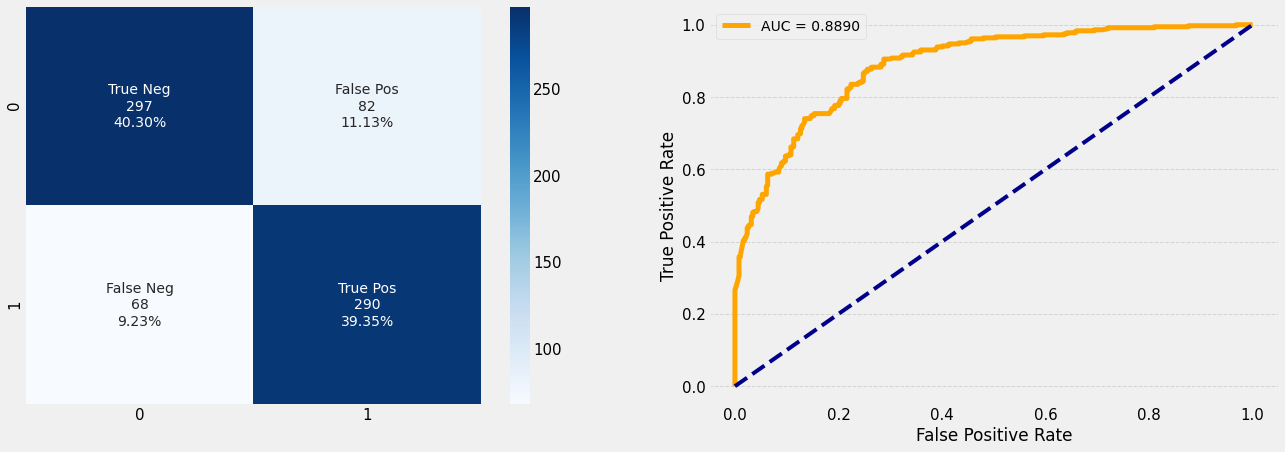

In [67]:
cf_matrix_roc_auc(lgb, y_test, lgb.predict(X_test), lgb.predict_proba(X_test)[:,1])

### Fonction objective

In [68]:
def objective(params, eval_metric='roc_auc'):
    
    #la fonction objective de minimisation. 
    #Hyperopt cherchera à minimiser la perte renvoyée par cette fonction.
    
    # On s'assure que les paramètres soient au bon format
    for parameter_name in ['num_leaves','max_depth','n_estimators']:
        params[parameter_name] = int(params[parameter_name])

    # Paramètres du modèle    
    params = {'n_estimators': params['n_estimators'], 
                        'class_weight': params['class_weight'],
                        'max_depth': int(params['max_depth']), 
                        'learning_rate': params['learning_rate'],
                        'subsample': params['subsample'],
                        'colsample_bytree': params['colsample_bytree'],
                        'num_leaves': int(params['num_leaves']),
                        'reg_alpha': params['reg_alpha'],
                        'reg_lambda': params['reg_lambda']
                       }
   
    model= LGBMClassifier(**params)
    #model.set_params(**params_model)
    cv = StratifiedKFold(5)
    if eval_metric == 'roc_auc': 
        score = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv).mean()

    elif eval_metric == 'custom_score':
        y_pred = cross_val_predict(model, X_train, y_train, method='predict', cv=cv)
        score = custom_score(y_train, y_pred)
  
    loss = 1 - score    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [69]:
%%time
 best = fmin(fn = objective,
                    space = space,
                    algo = tpe.suggest,
                    max_evals = 30,
                    trials = Trials(),
                    rstate = np.random.RandomState(1)
                   )   

100%|██████████████████████████████████████████████| 30/30 [02:18<00:00,  4.61s/trial, best loss: 0.010548111812780592]
Wall time: 2min 18s


In [70]:
%%time
lgb = LGBMClassifier( #Fit a new model based on the best parameters
    n_estimators=int(best['n_estimators']), 
    colsample_bytree= best['colsample_by_tree'],
    learning_rate= best['learning_rate'],
    max_depth= int(best['max_depth']),
    subsample= best['subsample'],
    class_weight= 'balanced',
    num_leaves= int(best['num_leaves']),
    reg_alpha= best['reg_alpha'],
    reg_lambda= best['reg_lambda'])

lgb.fit(X_train, y_train)


#pickle.dump(lgb, open("C:/Users/Agboto/Desktop/Projet_OpenClassrooms_Data_Science/Projet7_openclassrooms/LGBMClassifier.pkl", "wb"))                                            

Wall time: 1.67 s


LGBMClassifier(class_weight='balanced', colsample_bytree=0.6000000000000001,
               learning_rate=0.07366649463308203, max_depth=12,
               n_estimators=800, num_leaves=100, reg_alpha=0.1, reg_lambda=0.4)

In [71]:
roc_auc = roc_auc_score(y_test, lgb.predict_proba(X_test)[:,1])
print('AUC : %0.6f' %roc_auc)

AUC : 0.995209


In [72]:
from sklearn.metrics import roc_auc_score

In [73]:
print(classification_report(y_test, lgb.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97       379
         1.0       0.98      0.94      0.96       358

    accuracy                           0.96       737
   macro avg       0.97      0.96      0.96       737
weighted avg       0.97      0.96      0.96       737



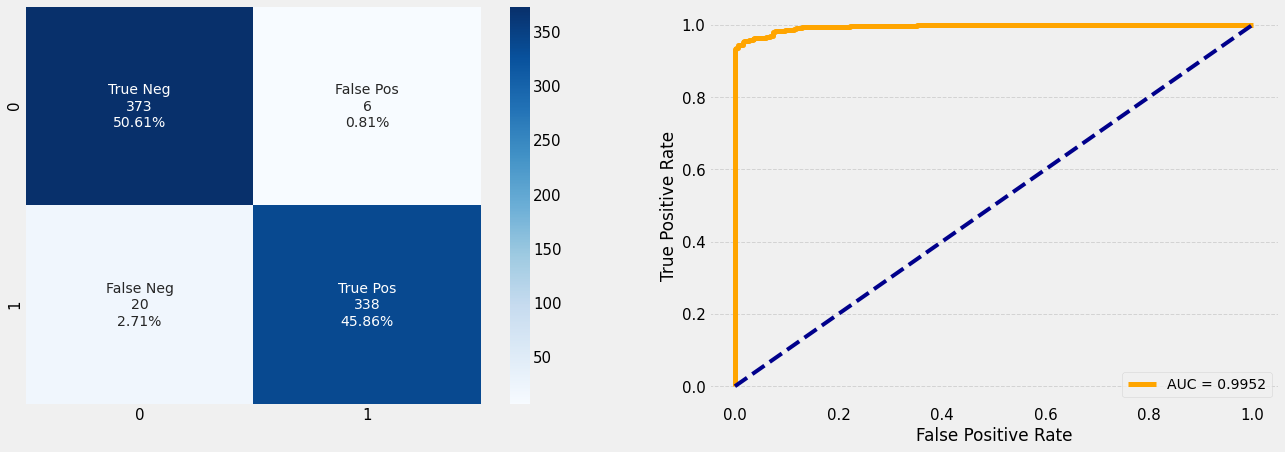

In [74]:
cf_matrix_roc_auc(lgb, y_test, lgb.predict(X_test), lgb.predict_proba(X_test)[:,1])

In [75]:
################################################################################################################################

# Interprétation du modèle

## <span style="color: ##0101DF;"> Interprétation avec la Librairie SHAP </span>  
On a implémenté la méthode **SHAP**(**SH**apley **A**dditive ex**P**lanation. L’idée proposée par ces auteurs est de calculer la valeur de Shapley pour toutes les variables à chaque exemple du dataset. Cette approche explique la sortie d’un modèle par la somme des effets de chaque variable. Ils se basent sur la valeur de Shapley qui provient de la théorie des jeux. L’idée est de moyenner l’impact qu’une variable a pour toutes les combinaisons de variables possibles.

**La valeur de Shapley d’une feature est alors la moyenne de la contribution de sa valeur à travers les différentes combinaisons.** 

**Exemple:** Pour simplifier, supposons que pour une instance donnée du dataset iris, notre modèle prédit la classe « versicolour » avec un score 60% lorsque la largeur des pétales est égale à 1.3cm, leur longueur est égale à 4.5cm, etc. Si en ne changeant que la valeur de la largeur des pétales, en remplaçant 1.3 par 2cm, le score baisse de 10%, alors la contribution de la valeur 1.3cm était de 10%. 

## INTERPRETATION GLOBALE

### Summary_plot : graphiques généraux
SHAP permet de calculer, pour chaque donnée, l’importance de chaque variable. Il suffit de faire la moyenne des importances afin d’avoir des importances « globales » pour chaque variable.
On obtient le graphique suivant

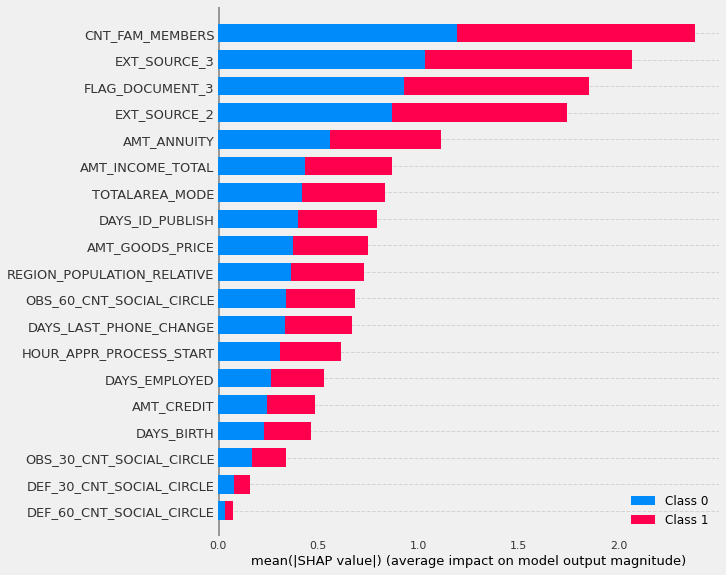

In [76]:
import shap
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

Wall time: 0 ns


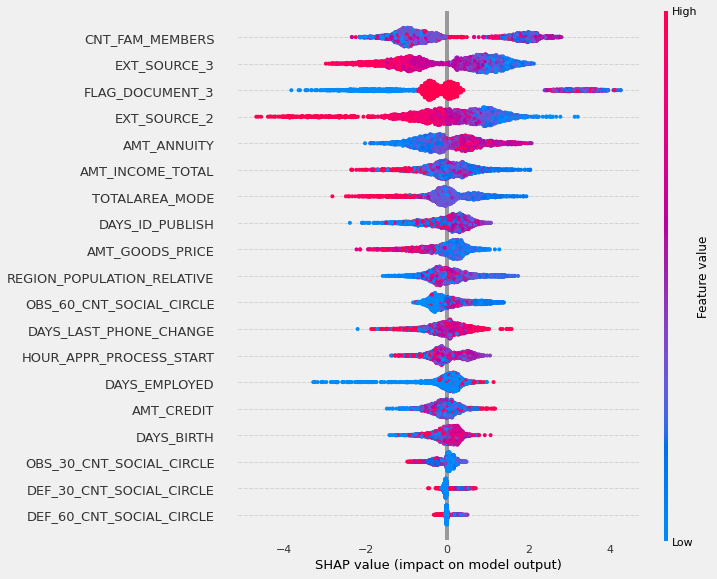

In [77]:
# Import the package
import shap
shap.initjs()

# Let us have a look on SHAP summary plot
%time
samples = X_train

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(samples, approximate=False, check_additivity=False)

shap.summary_plot(shap_values[1], samples)

### Analyses et interprétations
* Par exemple, les valeurs élevées de la variable **EXT_SOURCE_2** ont une contribution négative très élevée(**> - 4**) sur la prédiction, tandis que les valeurs faibles ont une contribution positive élevée (**2**).
* La variable **AMT_ANNUITY** a une contribution positive (**un peu plus de 2**) lorsque ses valeurs sont élevées et une contribution négative pour ses valeurs faibles (**un peu plus de -2**). 
* Toutes les variables sont affichées dans l'ordre **d'importance globale** des caractéristiques, la première étant la plus importante et la dernière étant la moins importante.

> En effet, SHAP peut nous montrer à la fois la **contribution globale** en utilisant les importances des caractéristiques et la contribution des caractéristiques locales pour chaque instance du problème par la diffusion du diagramme d'abeilles (beeswarm plot). 

### Dependence_plot : effet des variables les unes sur les autres
Le dependence_plot permet, comme son nom l’indique, d’explorer les dépendances entre variables.

Le **diagramme de dépendance** (dependence_plot)  partielle montre l'effet marginal qu'une ou deux variables ont sur le résultat prédit d'un modèle d'apprentissage automatique (JH Friedman 2001). Il indique si la relation entre la cible et une entité est linéaire, monotone ou plus complexe. Pour créer un diagramme de dépendance, vous n'avez besoin que d'une seule ligne de code : shap.dependence_plot("variable", shap_values, data). La fonction inclut automatiquement une autre variable avec laquelle la variable choisie interagit le plus.

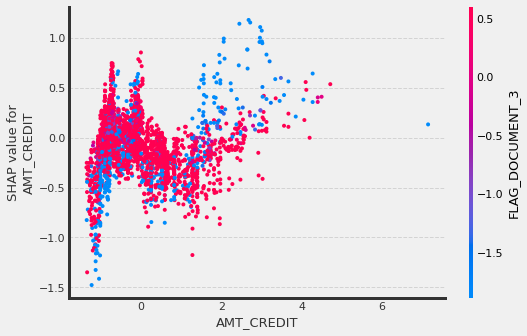

In [78]:
shap.dependence_plot('AMT_CREDIT', shap_values[1], samples)

In [79]:
col_desc('train','AMT_CREDIT') # Montant du crédit du prêt 

[['application_{train|test}.csv' 'AMT_CREDIT'
  'Credit amount of the loan ']]


In [80]:
col_desc('train','EXT_SOURCE_2') # Le client a-t-il fourni le document 3

[['application_{train|test}.csv' 'EXT_SOURCE_2'
  'Normalized score from external data source (normalized)']]


**Analyses et interprétations**

Chaque point correspond à une donnée ; son abscisse correspond à la valeur de la variable choisie (**Montant du crédit** ici) et son ordonnée à la **valeur SHAP de la variable**. La relation entre Montant du crédit et les données de SOURCE_EXT_2 est un peu complexe à expliquer.

## INTERPRETATION LOCALE

### Force_plot : graphique pour une donnée
Ces informations sont également affichable pour une donnée avec «force_plot». 

In [81]:
def shapley(X_train, y_train, X_test, row_number =0):
    pred = model.predict(X_test)
    row= X_test.iloc[[row_number]]
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(row)
    #get features names
    features_names = row.columns
    features_values = row.values[0]
    #shaps = pd.Series(shap_values[0], zip(features_names, features_values))
    # Visualizing the results of shap_values
    return shap.force_plot(base_value =explainer.expected_value[0], shap_values = shap_values[0], features = row)

La valeur de base (**base value**) est la valeur moyenne obtenue comme sortie pour cette classe, alors que la valeur de sortie (**model output value** ici f(x)) est la valeur prédite par le modèle. Les valeurs SHAP de chaque variable, proportionnelles aux tailles des flèches, « poussent » la prédiction depuis la valeur de base jusqu’à la valeur prédite. 

In [82]:
shapley(X_train, y_train, X_test, row_number =56)

In [83]:
shapley(X_train, y_train, X_test, row_number =425)